# Renderings Statistics

## Converting data

**RenderingsStatistics:** Convert data from a tables in a bunch of html files (CacheStatus.*.html)

First install dependency used in scripts below and import everything what is needed in this notebook

In [1]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


In [1]:
from datetime import datetime
from bs4 import BeautifulSoup
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

In [3]:
# Set the directory containing the HTML files
directory = "RenderingsStatistics"

# Initialize an empty list to store the CSV data
csv_data = []

# Initialize a flag to check if the header row has been added
header_added = False

# Loop through each HTML file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".html"):
        # Remove 'CacheStatus.' and 'RenderingsStatistics.' from the filename
        timestamp_str = filename.replace("CacheStatus.", "").replace("RenderingsStatistics.", "")
        # Parse the timestamp from the file name
        timestamp_str = timestamp_str.rsplit(".", 1)[0]
        timestamp = datetime.strptime(timestamp_str, "%Y%m%dZ.%H%M%SZ")

        # Read the HTML file
        with open(os.path.join(directory, filename), "r") as f:
            html = f.read()

        # Parse the HTML with BeautifulSoup
        soup = BeautifulSoup(html, "html.parser")

        # Find all tables in the HTML
        tables = soup.find_all("table")

        # Loop through each table
        for table in tables:
            # Find all rows in the table
            rows = table.find_all("tr")

            # Loop through each row
            for i, row in enumerate(rows):
                # Find all columns in the row
                cols = row.find_all(["th", "td"])

                # Initialize an empty list to store the column data
                col_data = []

                # Loop through each column
                for col in cols:
                    # Append the column data to the list
                    col_data.append(col.get_text().strip())

                # Skip the first row if the header row has already been added
                if i == 0 and header_added:
                    continue

                # Append the timestamp to the column data
                col_data.append(timestamp.strftime("%Y-%m-%d %H:%M:%S"))

                # Append the column data to the CSV data
                csv_data.append(col_data)

        # Set the flag to True if the header row has not been added yet
        if not header_added:
            header_added = True

# Write the CSV data to a file
with open("renderingsStatistics.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(csv_data)

Fix timestamp column name

In [4]:
with open('renderingsStatistics.csv', 'r') as f:
    reader = csv.reader(f)
    rows = list(reader)

# Replace the header value for the last column with "timestamp"
header_row = rows[0]
header_row[-1] = "timestamp"

with open('renderingsStatistics.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(rows)

Normalize data from ```renderingsStatistics.csv``` to convert Last Run field to datetime as well as Total time to the timedelta and store in new csv: ```renderingsStatisticsNormalized.csv```

In [4]:
def convert_time_column_to_milliseconds(df, column_name):
    df[column_name] = [int(t[:2])*3600000 + int(t[3:5])*60000 + int(t[6:8])*1000 + int(t[9:15])//1000 for t in df[column_name]]
    return df

# Load the CSV file into a pandas dataframe
df = pd.read_csv('renderingsStatistics.csv')

# Convert the Timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['Avg. time (ms)'] = df['Avg. time (ms)'].astype(float)
# Convert 'Lasat run' column to datetime, ignoring errors
try:
    df['Last run'] = pd.to_datetime(df['Last run'], format='%m/%d/%Y %I:%M:%S %p')
except:
    pass

# Convert 'Total time' column to timedelta
#df['Total time'] = [timedelta(seconds=float(t[3:])) for t in df['Total time']]
df = convert_time_column_to_milliseconds(df, 'Total time')

df.to_csv("renderingsStatisticsNormalized.csv", index=False, mode='w')

# Print a message to confirm that the file was saved
print("Filtered data saved to cacheStatusNormalized.csv")

Filtered data saved to cacheStatusNormalized.csv


Set the datetime range to work with further

In [20]:
# Load the CSV file into a pandas dataframe
df = pd.read_csv('renderingsStatisticsNormalized.csv')
# display(df)
# Convert the Timestamp column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

######## Set desired Date-time range to plot chart for. Comment out all the lines below to plot entire dataset.
# Set the start and end datetimes for the desired datetime range
start_datetime = pd.Timestamp('2023-06-07 13:50:00')
end_datetime = pd.Timestamp('2023-06-07 14:50:00')
# Filter the dataframe to only include rows within the desired datetime range
df = df[(df['timestamp'] >= start_datetime) & (df['timestamp'] <= end_datetime)]

Save the csv with the data from specific datetime range

In [21]:
df.to_csv("renderingsStatisticsNormalized-datetimewindow.csv", index=False, mode='w')

In [22]:
# read the CSV file into a pandas DataFrame
df = pd.read_csv('renderingsStatisticsNormalized-datetimewindow.csv')

# group the DataFrame by the 'Rendering' column and calculate the sum of the 'Total time (ms)' column
grouped_df = df.groupby('Rendering')['Total time (ms)'].sum()

# sort the resulting DataFrame by 'Total time' descending
sorted_df = grouped_df.sort_values(ascending=False)

# print the sorted DataFrame
print(sorted_df)
sorted_df.to_csv("renderingsStatisticsNormalized-groupped-sorted.csv", index=True, mode='w')

Rendering
View: /Views/Layouts/Default.cshtml                                                                                                      144608207
Controller: Howdens.Feature.MegaMenu.Controllers.MegaMenuController,Howdens.Feature.MegaMenu. Action: Header                              27090498
Controller: Howdens.Feature.Product.Controllers.ProductController,Howdens.Feature.Product. Action: ProductListing                         25932333
Controller: Howdens.Feature.Navigation.Controllers.NavigationController,Howdens.Feature.Navigation. Action: RenderBackgroundContainer     14760301
Controller: Howdens.Feature.Wrapper.Controllers.WrapperController,Howdens.Feature.Wrapper. Action: Wrapper                                13937629
                                                                                                                                           ...    
Controller: Howdens.Feature.Product.Controllers.ProductController,Howdens.Feature.Product. Action: ProductDo

/tmp/ipykernel_5056/3571512542.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])


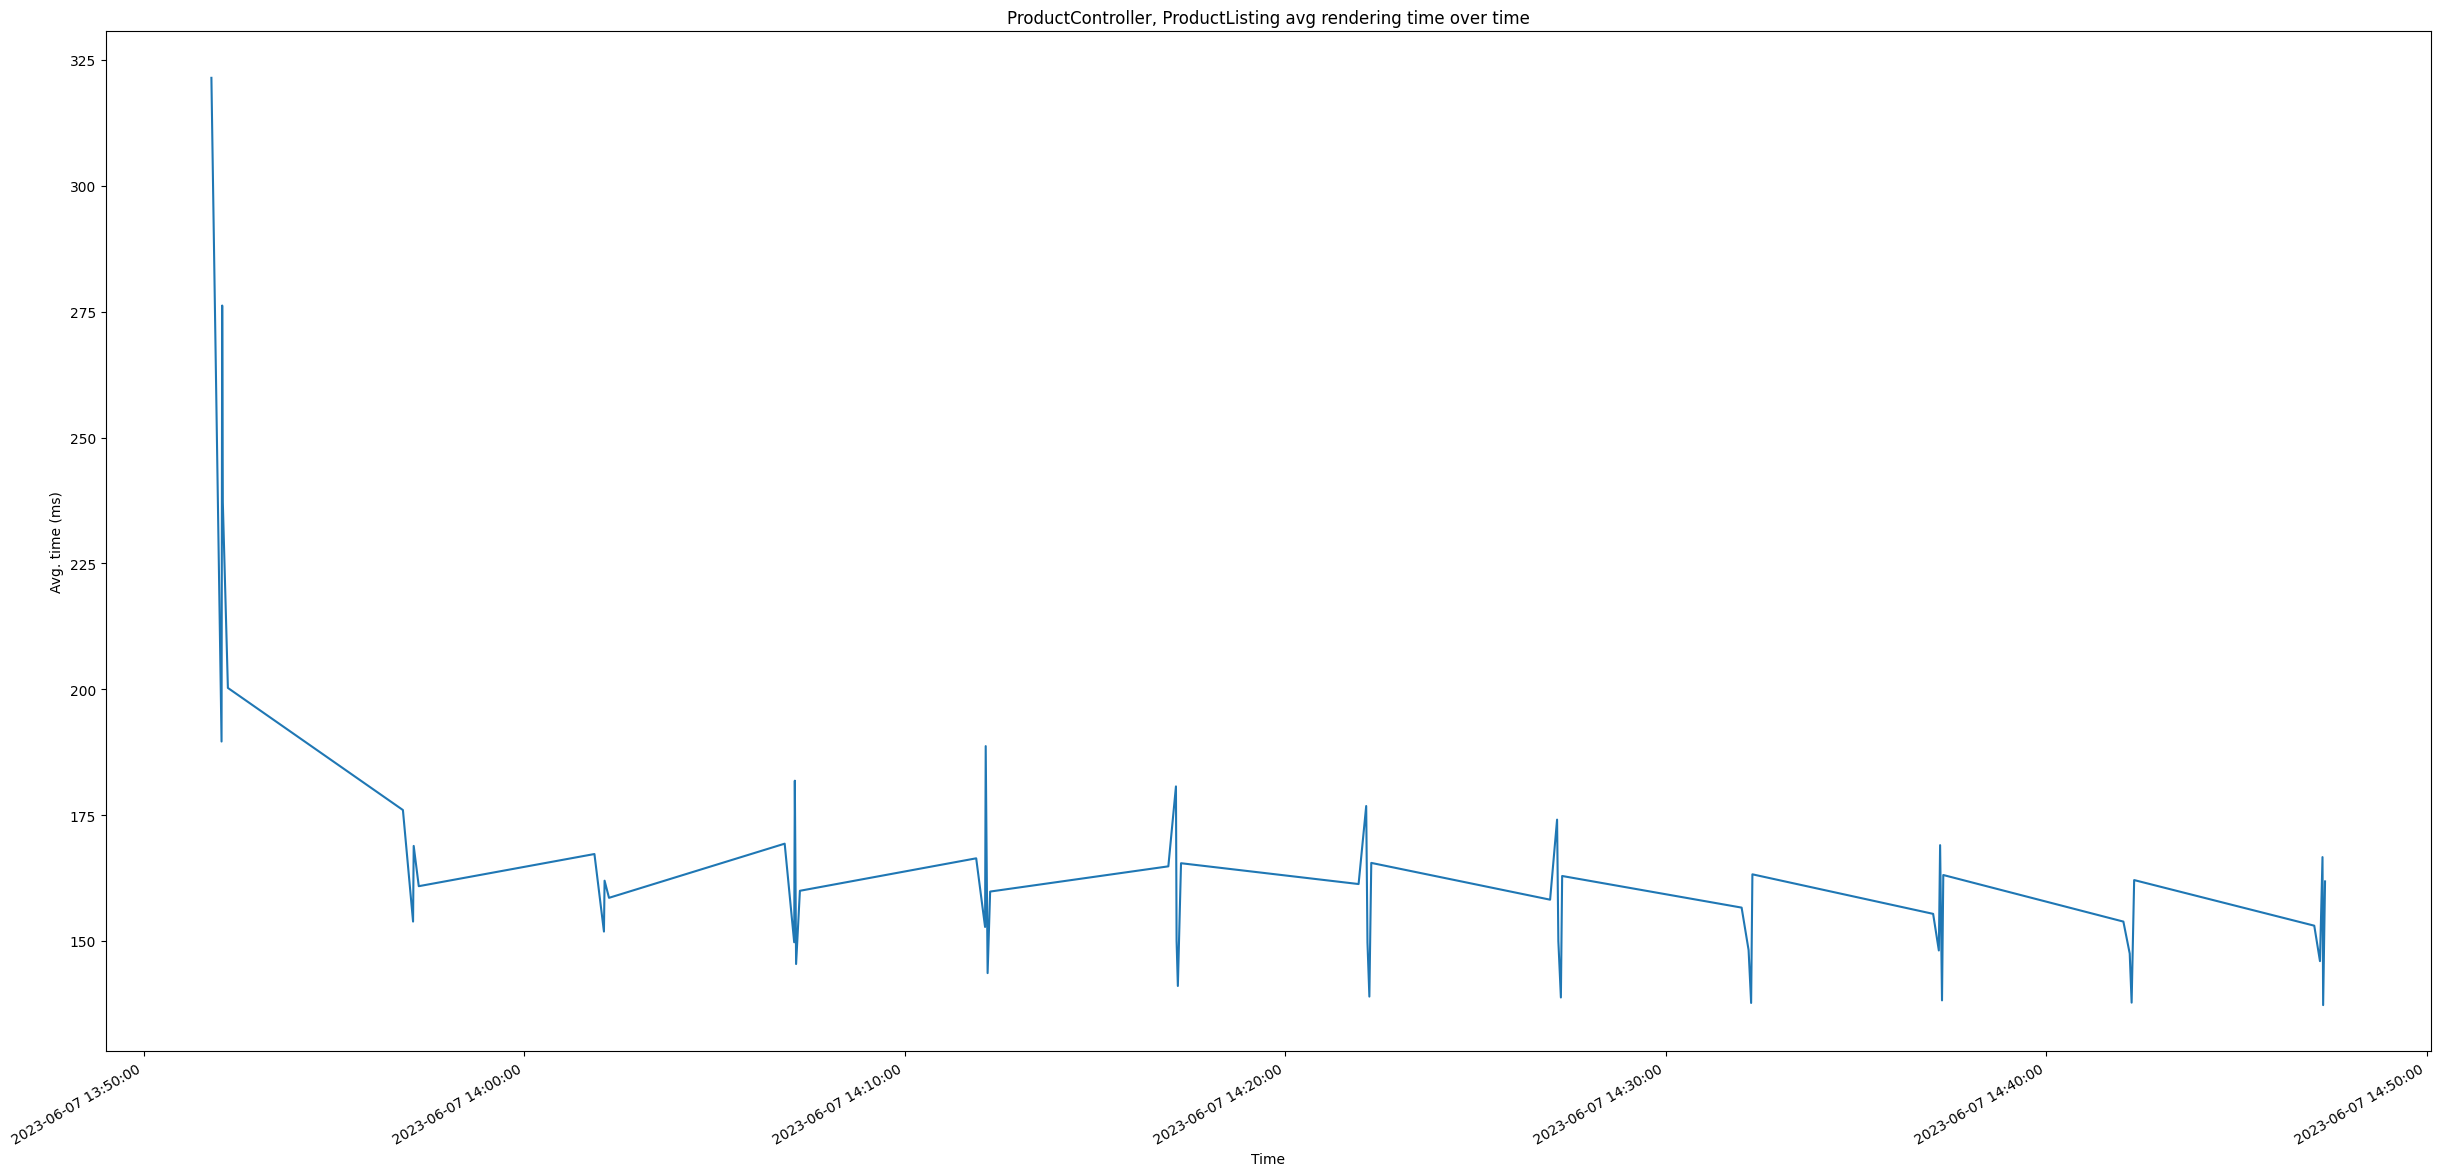

In [12]:
# Filter the DataFrame to only include rows with the specified name
name = 'Controller: Howdens.Feature.Product.Controllers.ProductController,Howdens.Feature.Product. Action: ProductListing'
filtered_df = df[df['Rendering'] == name]

# Convert the 'Last run' column to a datetime object
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])

# Set the 'Last run' column as the DataFrame index
filtered_df.set_index('timestamp', inplace=True)

# Create a new figure with a width of 10 inches and a height of 5 inches
plt.figure(figsize=(30, 15))

# Plot the 'Avg. time (ms)' column over time
ax = filtered_df['Avg. time (ms)'].plot()

# Define the datetime format for the y-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)

# Set the title and axis labels
plt.title('ProductController, ProductListing avg rendering time over time')
plt.xlabel('Time')
plt.ylabel('Avg. time (ms)')

# Show the plot
plt.show()

/tmp/ipykernel_5056/1262909322.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])


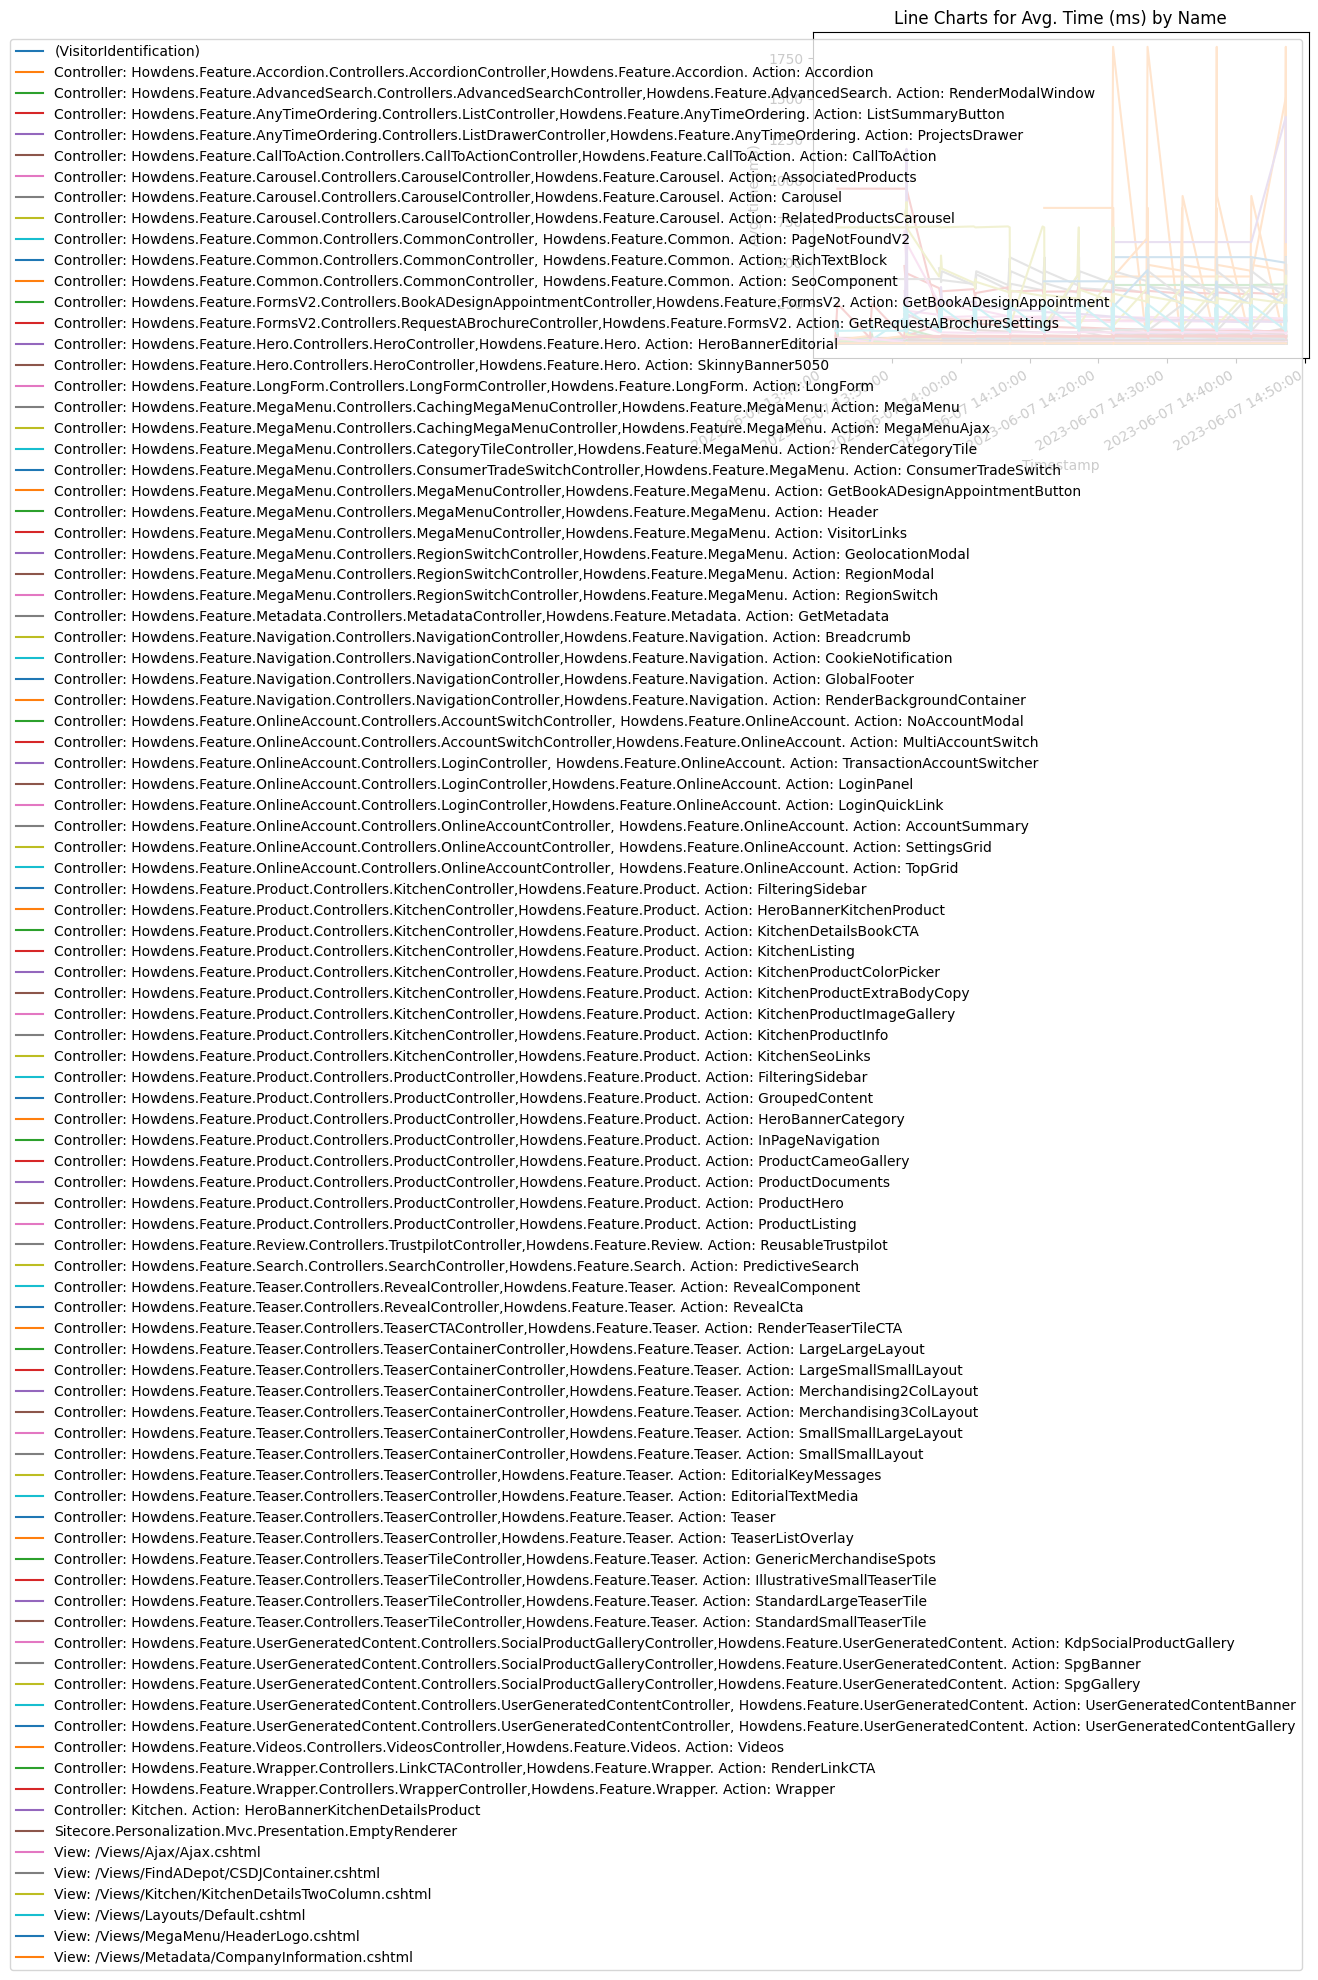

In [14]:
# Filter the DataFrame to only include rows with the specified name
name = 'Controller: Howdens.Feature.Product.Controllers.ProductController,Howdens.Feature.Product. Action: ProductListing'
filtered_df = df[df['Rendering'] == name]

# Convert the 'Last run' column to a datetime object
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'])

# Set the 'Last run' column as the DataFrame index
filtered_df.set_index('timestamp', inplace=True)

# Group the DataFrame by the 'name' column
grouped_df = df.groupby('Rendering')

# Create a figure and axis object
fig, ax = plt.subplots()

# Loop through each group and plot a line chart on the same axis
for name, group in grouped_df:
    group.set_index('timestamp', inplace=True)
    group['Avg. time (ms)'].plot(ax=ax, label=name)

# Set the axis labels and title
ax.set_xlabel('Timestamp')
ax.set_ylabel('Avg. time (ms)')
ax.set_title('Line Charts for Avg. Time (ms) by Name')

# Define the datetime format for the y-axis ticks
date_fmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
ax.xaxis.set_major_formatter(date_fmt)

# Show the legend and plot
ax.legend()
plt.show()